In [1]:
!git clone https://github.com/RijenSianturi/engineerninja


Cloning into 'engineerninja'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), done.


In [2]:
%cd /content/engineerninja

/content/engineerninja


In [3]:
!mkdir notebook

mkdir: cannot create directory ‘notebook’: File exists


In [34]:
#import
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

if(IS_LOCAL):
    PATH="../input/credit-card-fraud-detection"
else:
    PATH="../input" # Please update this path to your dataset location if it's not in '../input'
# print(os.listdir(PATH)) # Commented out to prevent FileNotFoundError

In [9]:
#get data form kaagle
!pip install kaggle
!mkdir -p ~/.kaggle
!mv /content/engineerninja/data/loginkaggle.json  ~/.kaggle/kaggle.json
!chmod 600  ~/.kaggle/kaggle.json

!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.54GB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [10]:
data_df = pd.read_csv('/content/engineerninja/data/creditcard.csv')

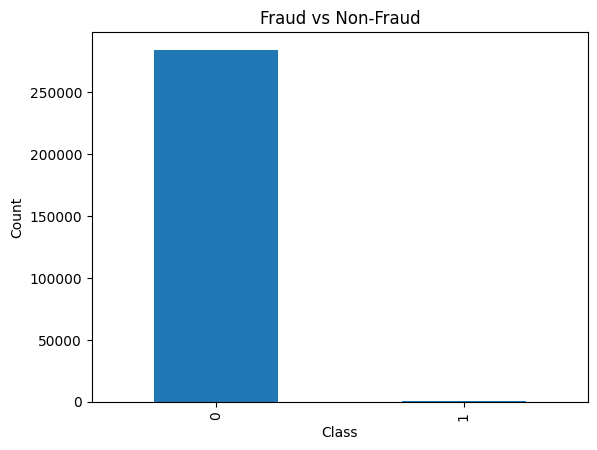

In [11]:
import matplotlib.pyplot as plt

data_df["Class"].value_counts().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Fraud vs Non-Fraud")
plt.show()


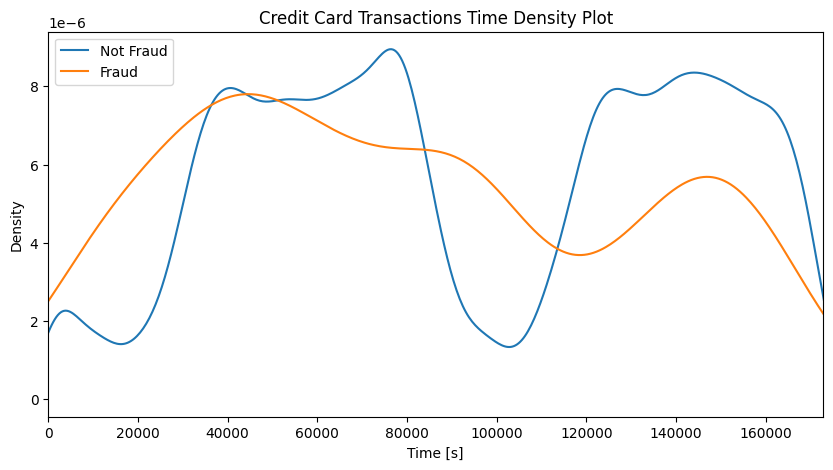

In [16]:
import matplotlib.pyplot as plt

class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

plt.figure(figsize=(10,5))
plt.xlim(0, data_df['Time'].max())

class_0.plot(kind='kde', label='Not Fraud')
class_1.plot(kind='kde', label='Fraud')

plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.ylabel('Density')
plt.legend()

plt.show()


In [15]:
print(data_df["Time"].min())
print(data_df["Time"].max())


0.0
172792.0


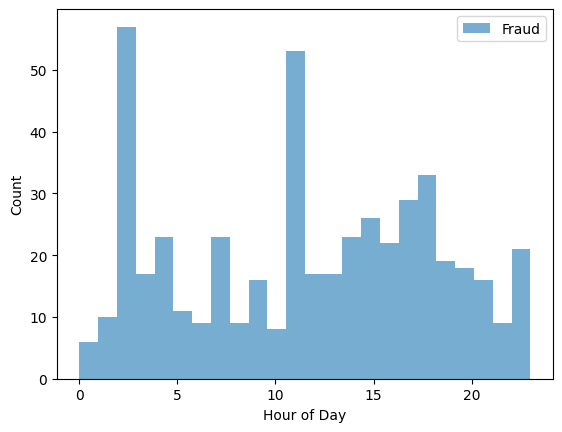

In [23]:
import matplotlib.pyplot as plt
data_df["Hour"] = (data_df["Time"] // 3600) % 24
fraud = data_df[data_df["Class"]==1]["Hour"]
normal = data_df[data_df["Class"]==0]["Hour"]

#plt.hist(normal, bins=24, alpha=0.6, label="Not Fraud")
plt.hist(fraud, bins=24, alpha=0.6, label="Fraud")

plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend()
plt.show()

##transaksi sampai 24  jam
#pik  20
#pik fraud subuh jam 3


In [38]:
#cek frekuensi transaksi
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x/3600)%24)

tmp= data_df.groupby(['Hour','Class'])['Amount'].aggregate(['min','max','count','sum','mean','var']).reset_index()
df = pd.DataFrame(tmp)

df.columns = ['Hour', 'Class', 'min', 'max', 'count', 'sum', 'mean', 'var']


In [32]:
#cek fraud terbanyak di rentang waktu jam brapa
fraud =  df[df["Class"]==1].sort_values(by=['sum'], ascending=False)
fraud.head()

,Hour,Class,min,max,count,sum,mean,var
23,11.0,1,0.00,802.52,53,6570.73,123.976038,41591.025374
37,18.0,1,0.00,1504.93,33,6345.14,192.276970,154501.341934
5,2.0,1,0.01,1809.68,57,4517.98,79.262807,64634.574781
33,16.0,1,0.00,1389.56,22,4505.45,204.793182,136328.979261
29,14.0,1,0.00,727.91,23,3641.12,158.309565,56646.657713


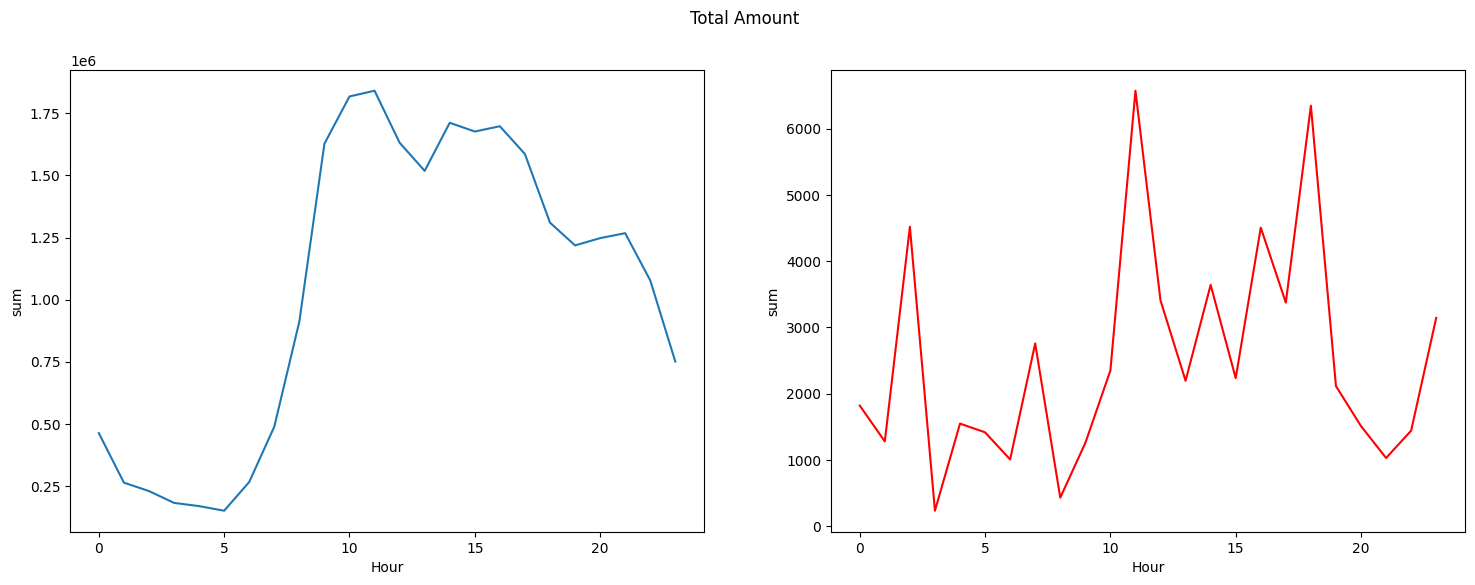

In [35]:
#ploting transaksi dengan sns
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

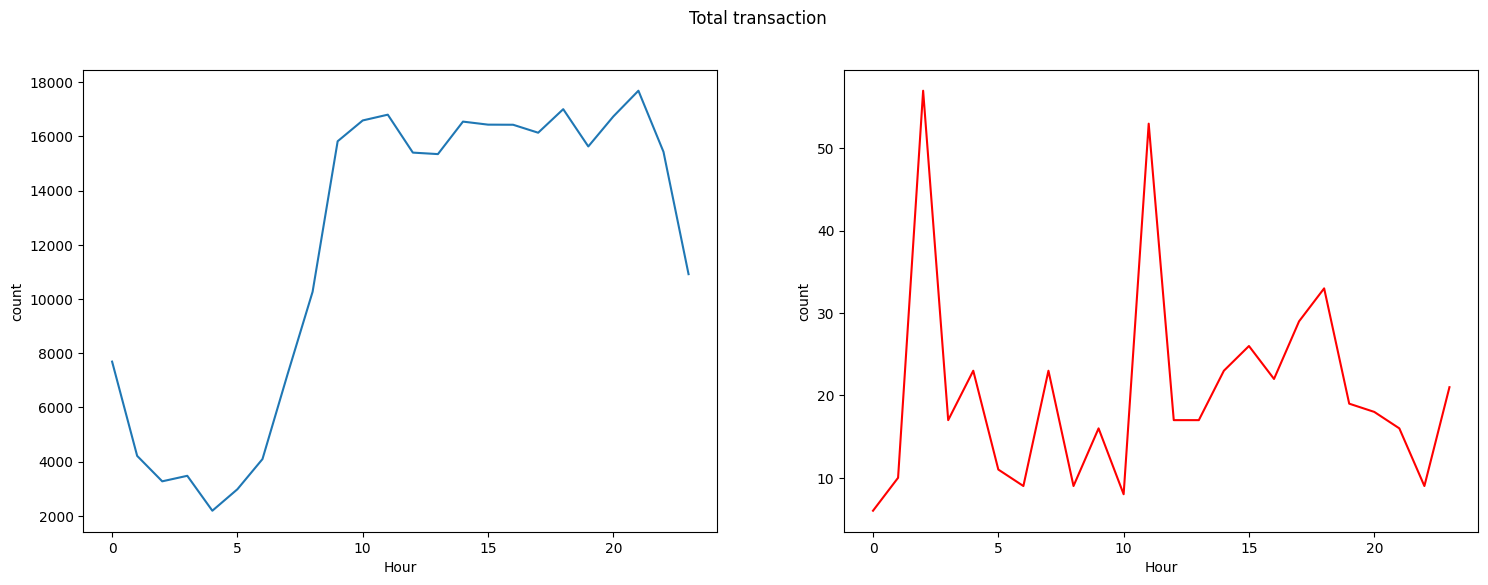

In [39]:
#ploting transaksi dengan sns
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="count", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="count", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total transaction")
plt.show();

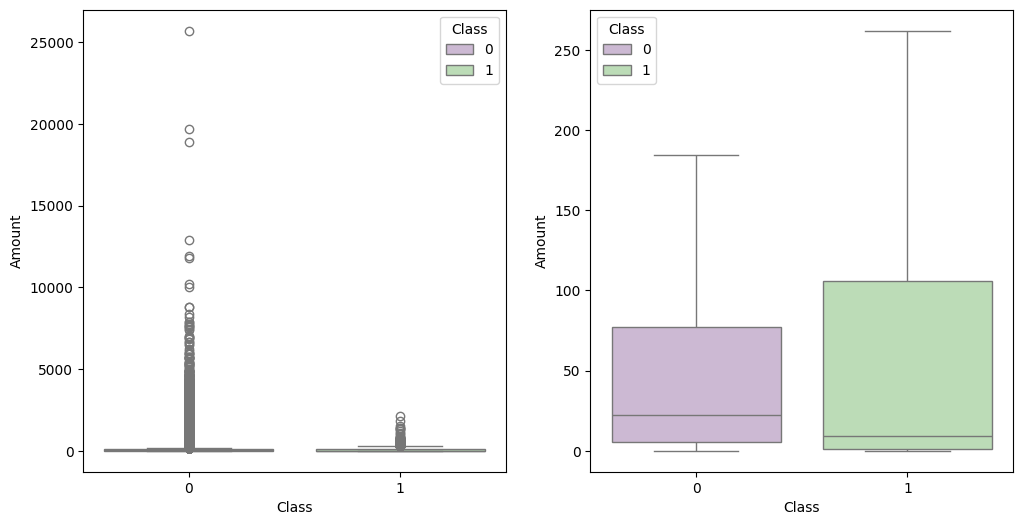

In [40]:
#amount transactions

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [41]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


In [42]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_1.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


In [43]:
#standar dev , more spread out more variatif data

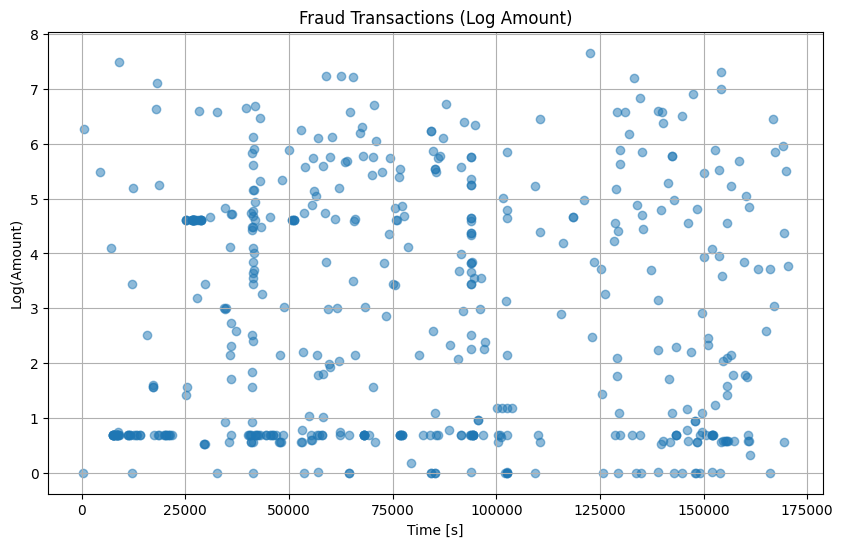

In [46]:
import numpy as np

plt.figure(figsize=(10,6))

plt.scatter(
    fraud['Time'],
    np.log1p(fraud['Amount']),
    alpha=0.5
)

plt.title('Fraud Transactions (Log Amount)')
plt.xlabel('Time [s]')
plt.ylabel('Log(Amount)')

plt.grid(True)
plt.show()


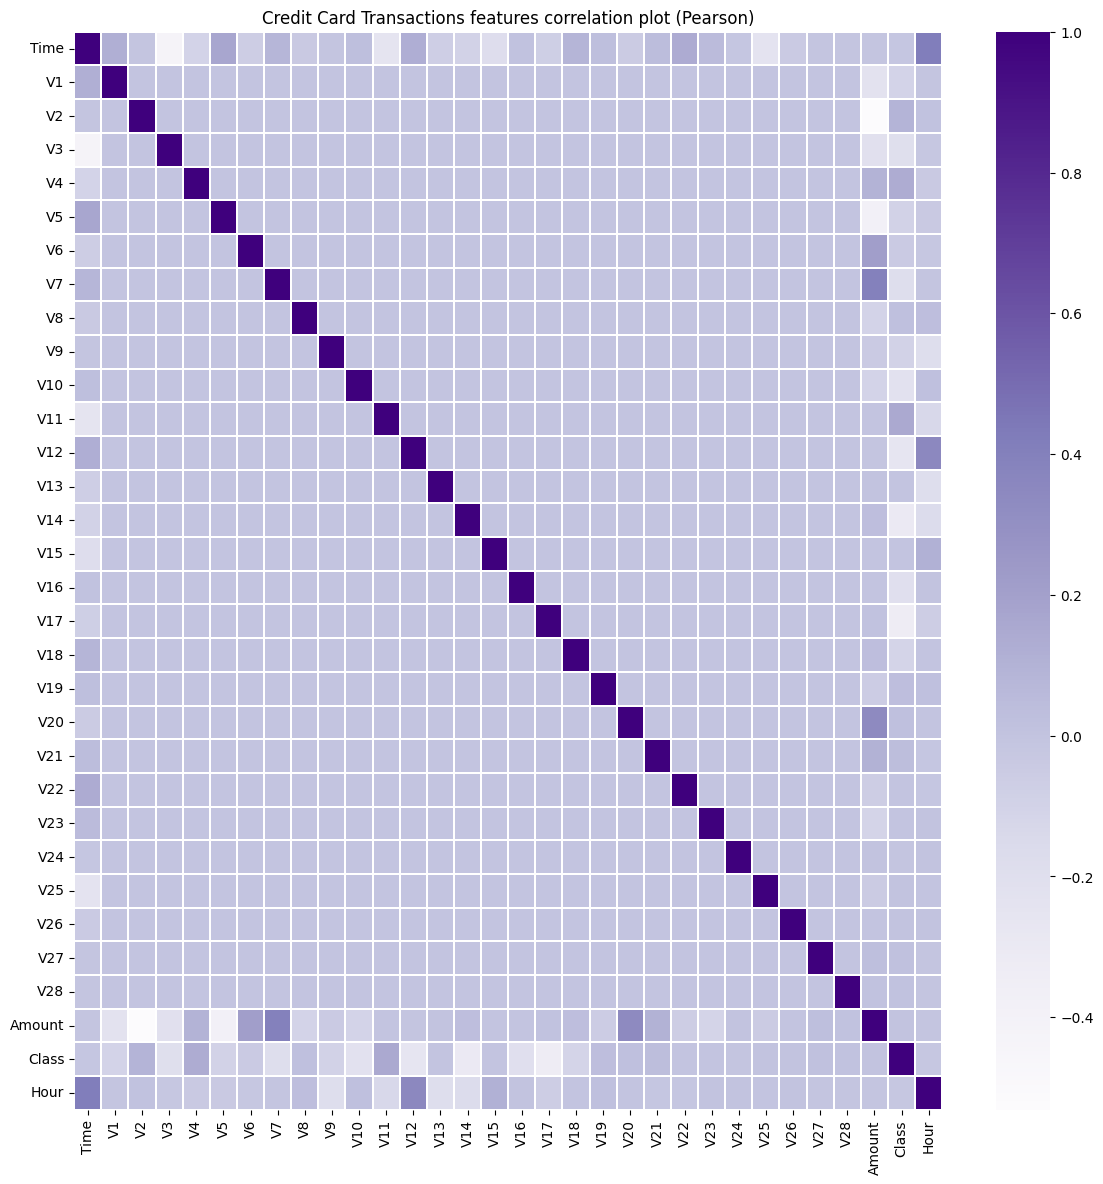

In [51]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Purples")
plt.show()

Paling pengaruh v7 dan amount let count v7 and amount

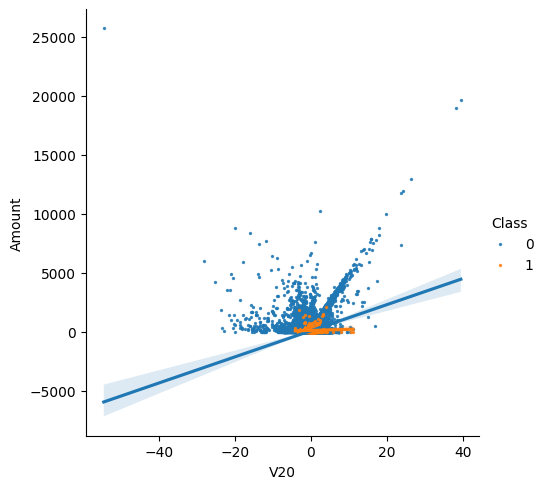

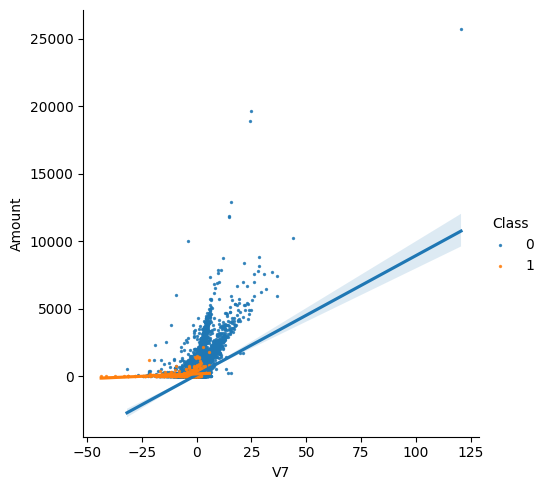

In [52]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

/tmp/ipython-input-955923673.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-955923673.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-955923673.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-955923673.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameter

<Figure size 640x480 with 0 Axes>

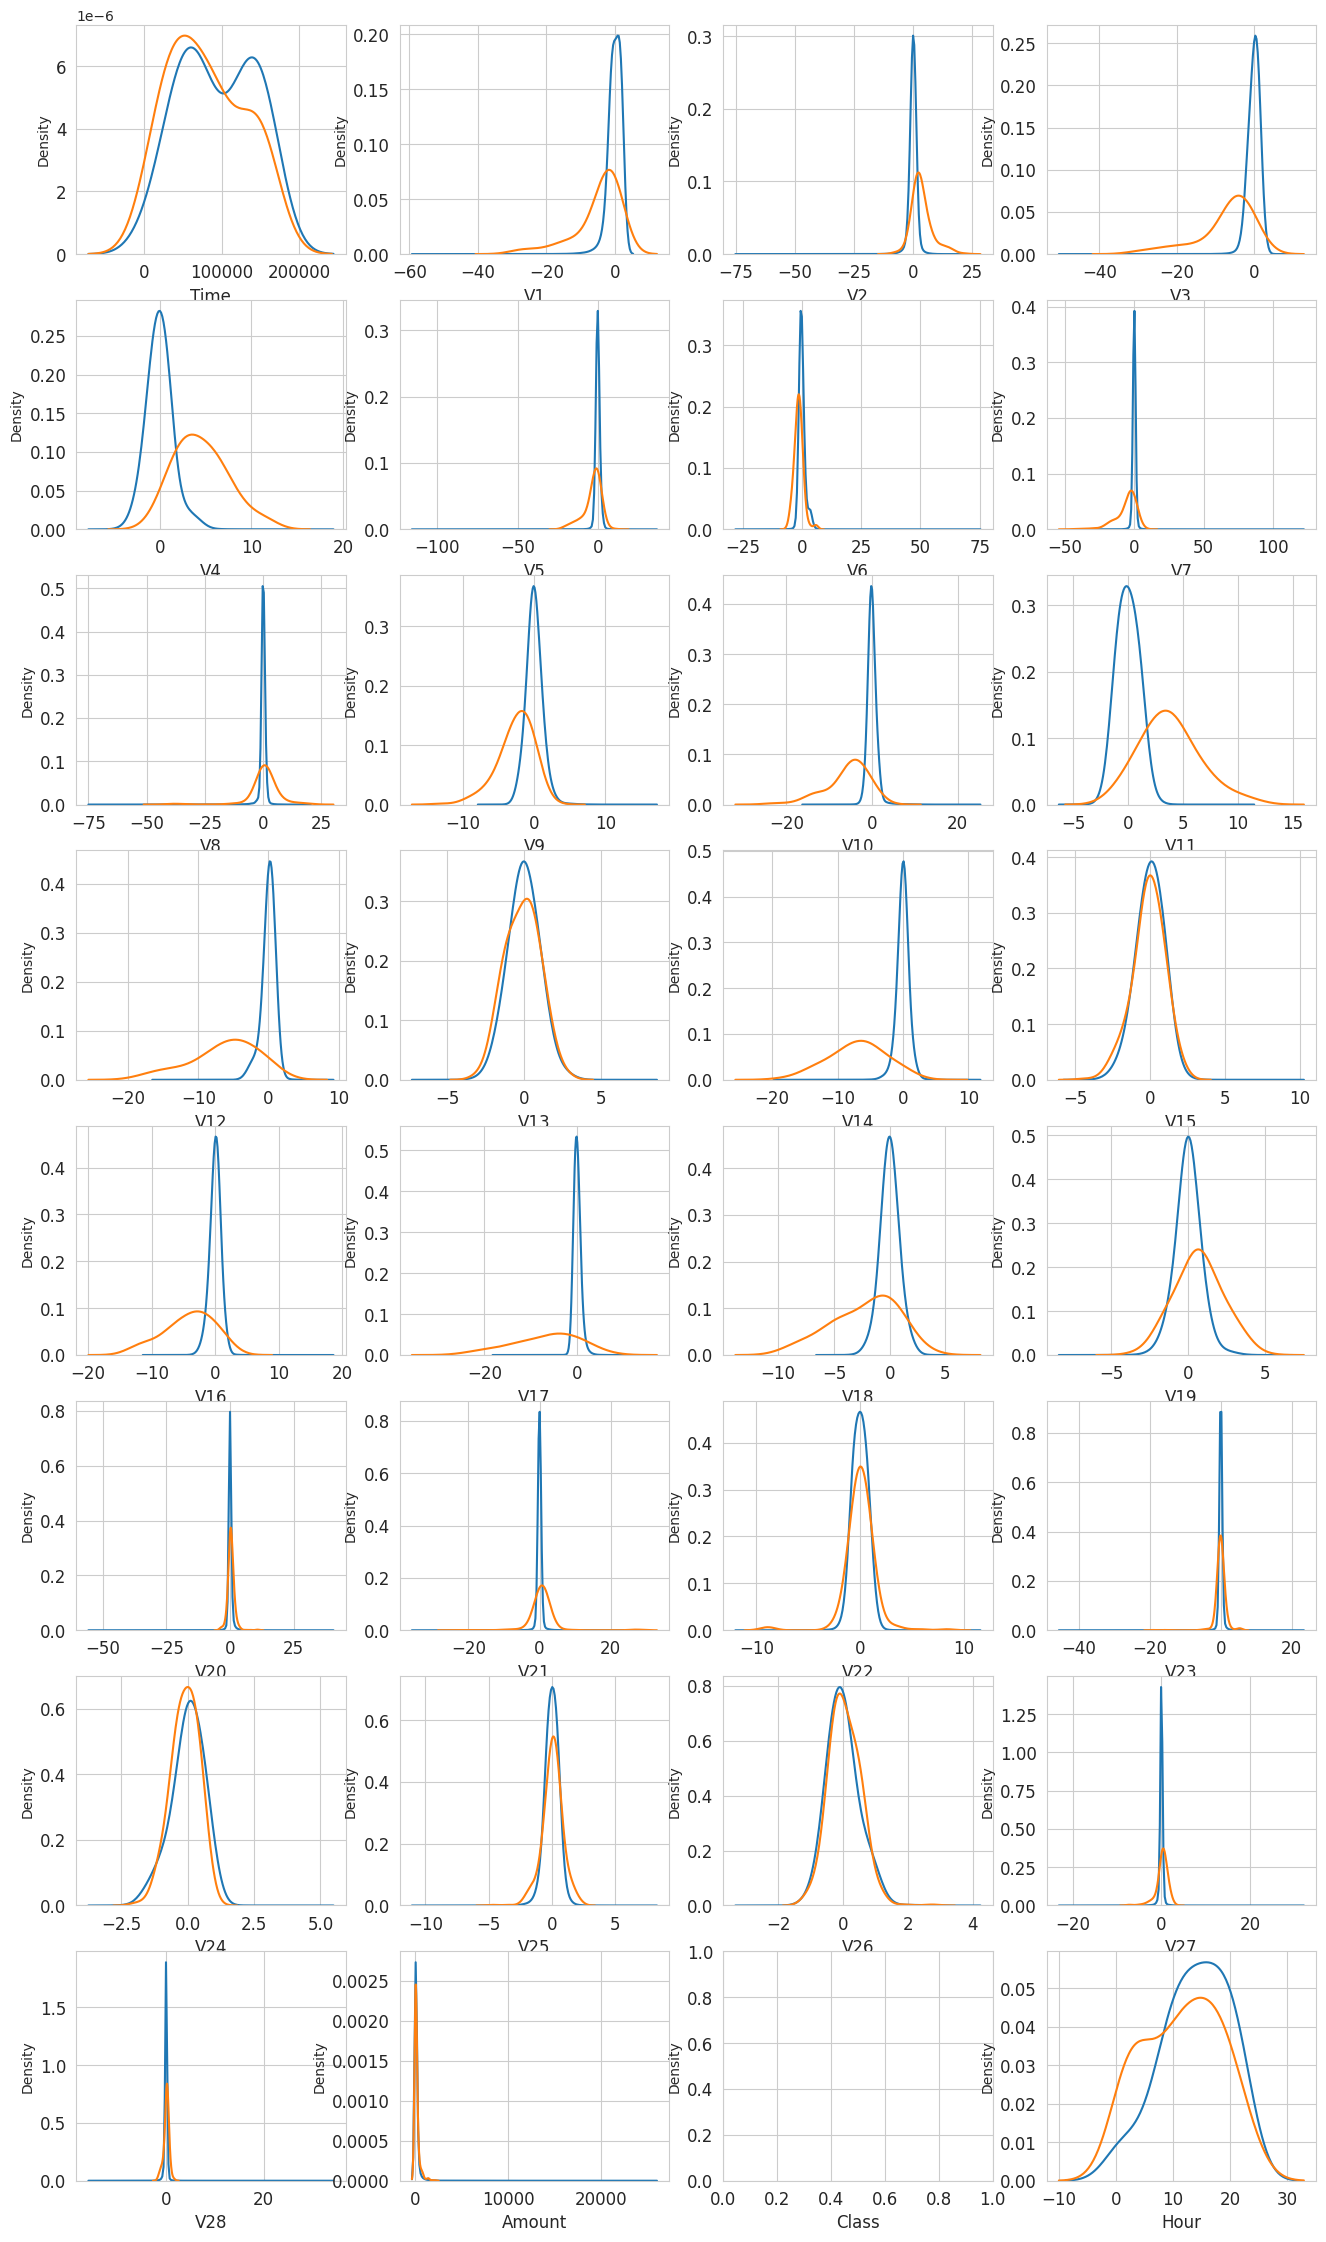

In [53]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [54]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [55]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [56]:
#random forest
clf = RandomForestClassifier(n_jobs=NO_JOBS, random_state=RANDOM_STATE,criterion=RFC_METRIC,n_estimators=NUM_ESTIMATORS,verbose=2)
clf.fit(train_df[predictors], train_df[target].values)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.4min finished


RandomForestClassifier(n_jobs=4, random_state=2018, verbose=2)

In [57]:
preds = clf.predict_proba(valid_df[predictors])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


/tmp/ipython-input-3992975389.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



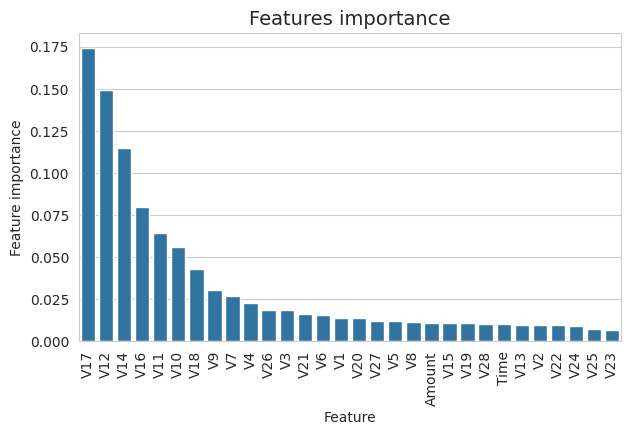

In [58]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

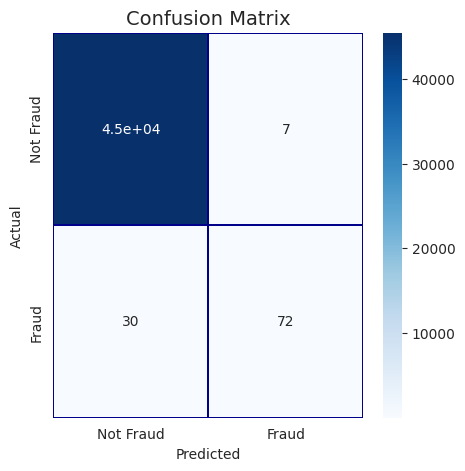

In [60]:
cm = pd.crosstab(valid_df[target].values, np.argmax(preds, axis=1), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [63]:
roc_auc_score(valid_df[target].values, preds[:, 1])

np.float64(0.9097061130740374)

In [73]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [74]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [75]:
preds = clf.predict_proba(valid_df[predictors])

/tmp/ipython-input-3992975389.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



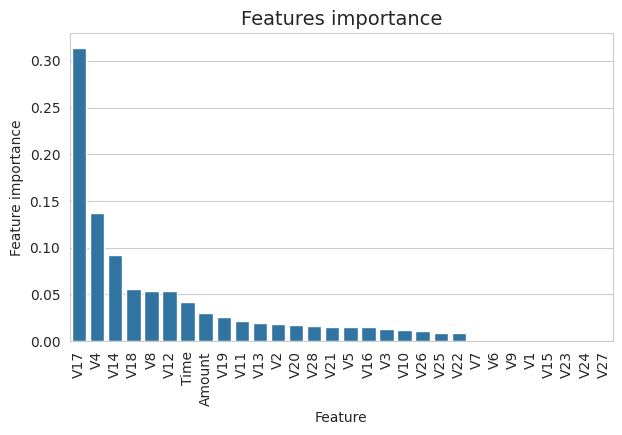

In [76]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

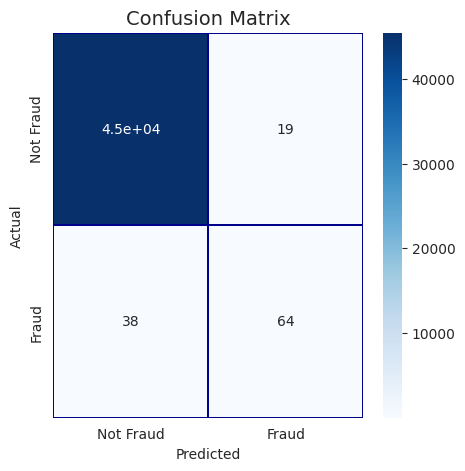

In [78]:
cm = pd.crosstab(valid_df[target].values, np.argmax(preds, axis=1), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [79]:
roc_auc_score(valid_df[target].values, preds[:, 1])

np.float64(0.9833898060950907)

In [80]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [81]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 1.69s	remaining: 14m 1s
50:	total: 35.5s	remaining: 5m 12s
100:	total: 1m 8s	remaining: 4m 29s
150:	total: 1m 38s	remaining: 3m 46s
200:	total: 2m 10s	remaining: 3m 13s
250:	total: 2m 42s	remaining: 2m 40s
300:	total: 3m 12s	remaining: 2m 7s
350:	total: 3m 41s	remaining: 1m 34s
400:	total: 4m 13s	remaining: 1m 2s
450:	total: 4m 44s	remaining: 30.9s
499:	total: 5m 13s	remaining: 0us


In [82]:
preds = clf.predict_proba(valid_df[predictors])

/tmp/ipython-input-1035525770.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



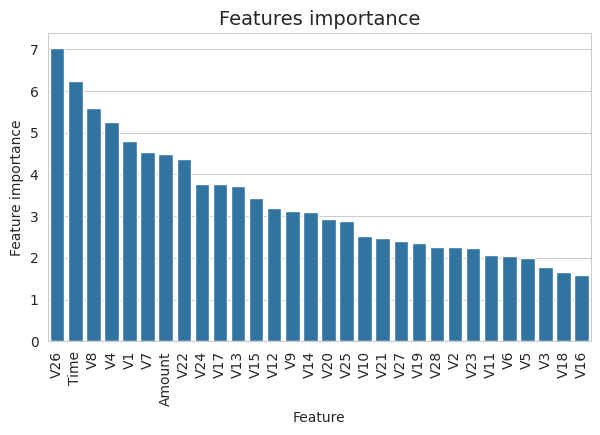

In [83]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

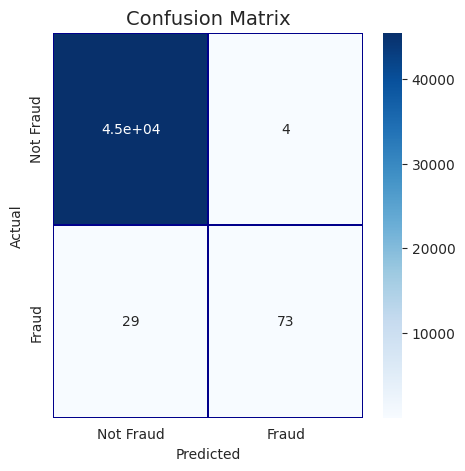

In [84]:
cm = pd.crosstab(valid_df[target].values, np.argmax(preds, axis=1), rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [85]:
roc_auc_score(valid_df[target].values, preds[:, 1])

np.float64(0.984340722014717)

In [86]:
import os
print(os.getcwd())

/content/engineerninja


In [87]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!

In [90]:
!ls /content/drive/MyDrive/Colab\ Notebooks/CCFRAUD.ipynb


'/content/drive/MyDrive/Colab Notebooks/CCFRAUD.ipynb'


In [ ]:
cp